7/11/24\
Author: Michael Stoll\
\
Over the duration of this class, I've been listening to a lot of music while I work. In fact, I've been listening to music while I work on homework since I was in middle school, but only now that I've learned something about ML has it occurred to me just how inefficient of an experience it has been. I can't count the amount of times that I have been in the mood for a particular song, only to get sick of it because of how many times I've put it on repeat. And if I try to find other songs that are similar to it, more often than not I come up empty handed anyway. Even the algorithms that are designed to give you a mix of music that is similar to what you are feeling in that moment seem to do little more than guess, so I end up yielding to the inaccurate and unreceptive playlist I'm given, accepting that I can't really do anything about it.\
\
That changes here.\
\
This project (working title "Delphi", in reference to the Oracle) is the combination of my musical and ML knowledge. By the end, I hope to have an web/Android app (or direct integration into a music service, God willing) that will do what I have always wanted a music app to do: listen.\
\
I intend to achieve this by providing the user with a few "preset" profiles to roughly match different music tastes, then allow them to provide feedback in the app to directly influence the songs recommended to them in specific ways. For example, if one user has a different threshold of anger than another, they will be able to tell the app that that is the case, and the app will actually change the values associated with that user's song library accordingly. Then they can pick a mood and have songs chosen for them that most closely match that mood.\
\
Of course, that's a bit ambitious for this class. I'm not sure if it's actually possible, to be entirely honest. The file size alone might mean that I have to completely rethink the project, and this isn't going to be something that I can finish in the next two months.\
\
However, the first ML heavy part of this project is something that I can do now: "vibe" prediction. This is going to be the core of the algorithm, and it's reasonably straightforward, which you will see when I get a bit more specific in a moment. First I feel the need to show you the data that I'm working with.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv("song-info.csv", sep=",")
data = data.dropna()
data["BPM"] = data["BPM"].astype(int)

#TODO: categorize Key
#this is for the future. maybe it will increase accuracy, maybe not. but that's a lot of preprocessing.

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307 entries, 0 to 361
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Song Title    307 non-null    object 
 1   Artist        307 non-null    object 
 2   Album         307 non-null    object 
 3   BPM           307 non-null    int32  
 4   Key           307 non-null    object 
 5   Aggression    307 non-null    float64
 6   Happiness     307 non-null    float64
 7   Soul          307 non-null    float64
 8   Chaos         307 non-null    float64
 9   Chill         307 non-null    float64
 10  Danceability  307 non-null    float64
 11  Singability   307 non-null    float64
 12  Intimate      307 non-null    float64
 13  Vibe          307 non-null    float64
dtypes: float64(9), int32(1), object(4)
memory usage: 34.8+ KB


The dataset is actually all hand-typed, by me. Yes it is small at the moment, but that's because it was all manually done. The thought is that once there is enough training data I will only have to do slight tweaks here and there as the model inevitably makes mistakes. Baby steps.\
\
Now that you've seen what the data technically is, allow me to explain: I have decided that, in my opinion, there are 8 distinct factors that determine the mood of a particular song. These are Aggression, Happiness, Soul, Chaos, Chill, Danceability, Singability, and Intimacy.\
\
An issue that we are going to run into in this explanation is the intangibility of these concepts; for example I'm not sure how exactly to describe what I mean by Soul, but I know it when I hear it.\
\
Anyway, it doesn't totally matter what I mean by each of these categories, since ultimately they are going to be customized to each person and this is just a representation of mine. The only important part is that each of them is on a scale of 0 to 10, where 5 is neutral, 10 is maximum, and 0 is the opposite of the listed emotion or quality. For example, if a song is a 5 in Happiness it is neither happy nor sad, and 10 indicates pure joy, and 0 indicates pure sorrow.\
\
So this begs the question, where does "vibe" come into play?\
\
In work on this project, I knew that I needed some singular quantifier to begin to describe a song to the model. After several reworks, I settled on the fact that it has to be a multistage ordeal with reorganization and predictions in several places, but for the sake of this assignment I'm going to keep it simple and deal with the first important building block: vibe.\
\
Vibe is another sort of intangible concept, but the basic idea behind it is that some songs are happy, some are sad, some are angry, and the rest are somewhere in between. To illustrate this part, I'm going to include an image here:

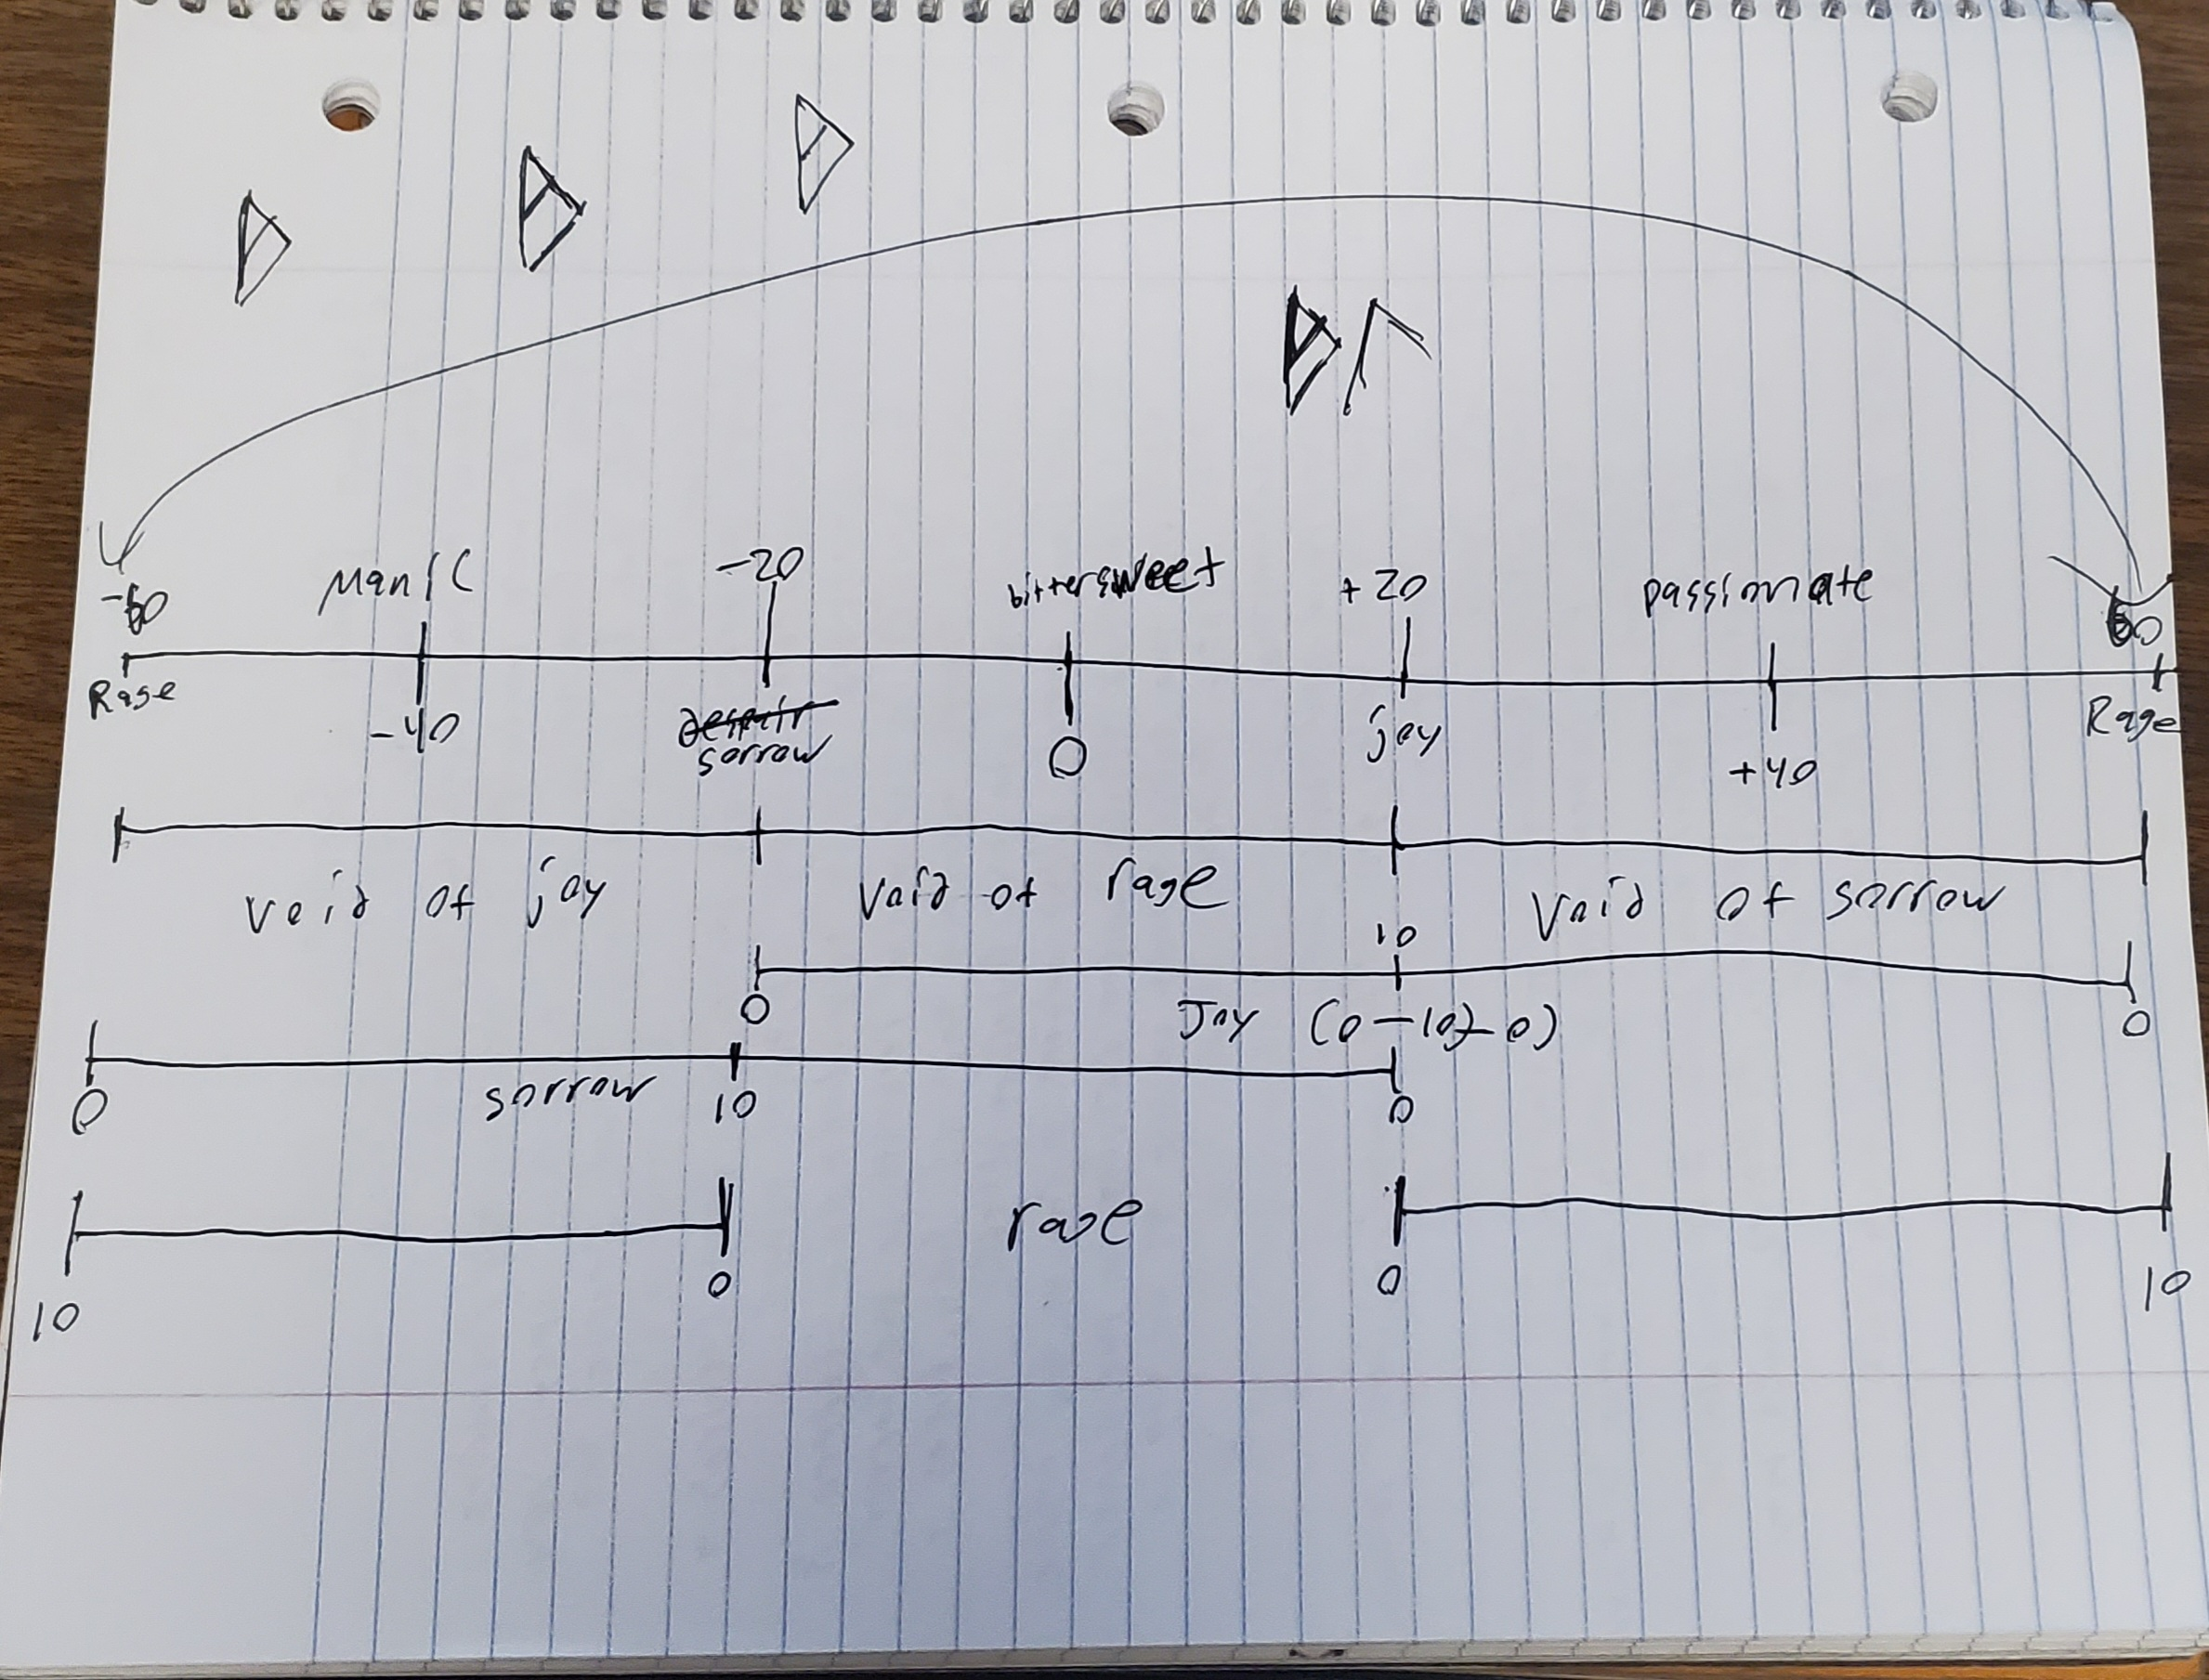

Please forgive the scribbles. This line graph is how I believe the music spectrum works: if you start from joy and gain anger, you move from joy to passion to rage. If you instead gain sorrow, you move from joy to bittersweet to sorrow. If you gain anger from sorrow, you move through what I call manic on the way to rage. Notably, in this graph, -60 = 60. I just don't have a way to represent this as the circle I would like to.\
\
You may wonder, why 60? And why is the center at 0? The answer to both of these questions is "convenience". I wanted to continually remind myself that -60 = 60, and since I have 3 main points along the line I wanted a number that was easily divided by 3. The sky is the limit when you get to make it up.\
\
So, of course, the goal is to get a regression to predict the vibe of a song so it can be grouped with similar songs. Now that all of that text is out of the way, it's finally time to start working.

In [2]:
from sklearn.model_selection import train_test_split

features = data.drop(columns=['Song Title', 'Artist', 'Album', 'Vibe', 'Key'])
target = data["Vibe"]
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.2, random_state= 721)

More out of curiosity than anything else, I've created a heatmap to compare the features and see how they align.

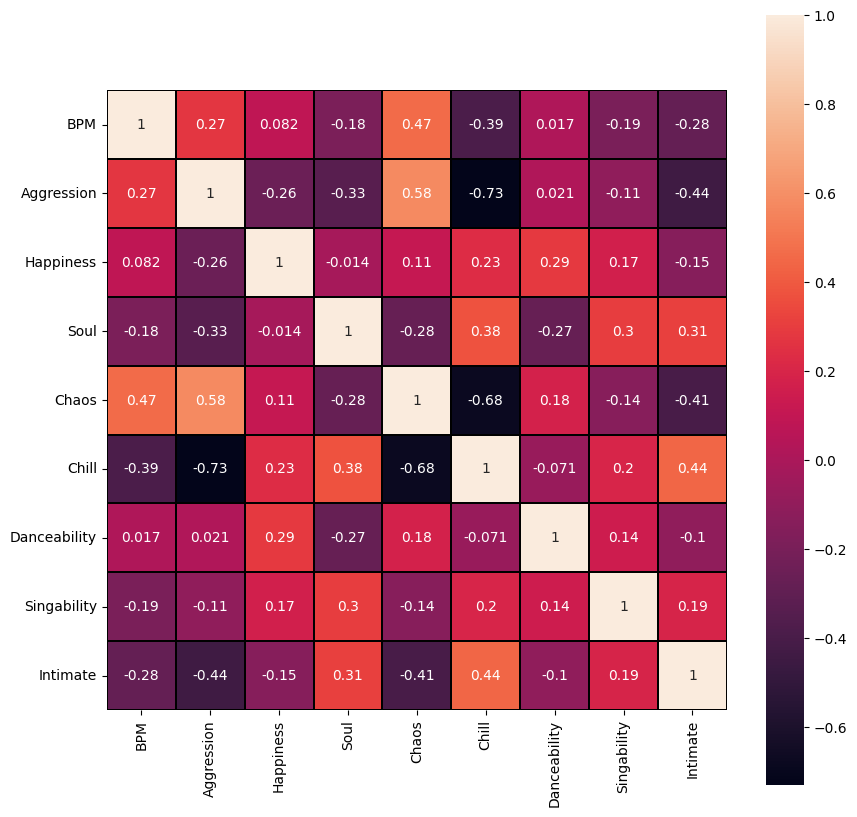

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(features)
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), square = True, annot=True, annot_kws={'fontsize':10}, linewidths=.1, vmax=1, linecolor='black')
plt.show()

I was pleasantly surprised by how strong some of these correlations are. Of course, the strongest ones are negative correlations, but even that is informative.\
\
Since I've learned how to do hyperparameter optimization, I've decided it's a good idea for this project as well, so now I'm building HP search spaces. Below this code you'll find a table that represents how the search spaces are utilized by each regressor.

In [12]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tabulate import tabulate

estimators = list(range(100,1000))
maxFeatures = ['sqrt', 'log2', None]
minSplit = list(range(2,20))
minLeaf = list(range(1,5))
randomGrid = {'n_estimators':estimators, 'max_features':maxFeatures, 'min_samples_split':minSplit, 'min_samples_leaf':minLeaf}

maxIter = list(range(100,1000))
gamma = ['scale', 'auto']
degree = list(range(3,26))
svcGrid = {'max_iter':maxIter, 'gamma':gamma, 'degree':degree}

splitter = ['best', 'random']
maxDepth = list(range(3,200))
dtGrid = {'splitter':splitter, 'max_depth':maxDepth, 'min_samples_split':minSplit, 'min_samples_leaf':minLeaf}

gbGrid = {'max_depth':maxDepth, 'max_features':maxFeatures, 'min_samples_leaf':minLeaf, 'min_samples_split':minSplit}

space = [svcGrid, dtGrid, gbGrid, randomGrid]
models = [SVR(), DecisionTreeRegressor(), GradientBoostingRegressor(),RandomForestRegressor()]

searchSpaces = [['Attribute Name', 'Attribute Range', 'SVR', 'Decision Tree', 'Gradient Boost', 'Random Forest'], 
                ['n_estimators', '(100-1000)', '', '', '', '900'],
                ['splitter', '(Best, Random)', '', '2', '', ''],
                ['max_depth', '(3-200)', '', '197', '197', ''],
                ['min_samples_split', '(2-20)', '', '18', '18', '18'],
                ['min_samples_leaf', '(1-5)','', '5', '5', '5'],
                ['max_features', '(sqrt, log2, None)','', '', '3', '3'],
                ['gamma', '(Scale, Auto)', '2', '', '', ''],
                ['max_iter', '(100-1000)', '900', '', '', ''],
                ['degree', '(3-26)', '23', '', '', ''],
                ['', 'Total Combos:', 2*23*900, 2*197*18*5, 197*18*5*3, 900*18*5*3]]
print(tabulate(searchSpaces, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════════╤════════════════════╤═══════╤═════════════════╤══════════════════╤═════════════════╕
│ Attribute Name    │ Attribute Range    │ SVR   │ Decision Tree   │ Gradient Boost   │ Random Forest   │
╞═══════════════════╪════════════════════╪═══════╪═════════════════╪══════════════════╪═════════════════╡
│ n_estimators      │ (100-1000)         │       │                 │                  │ 900             │
├───────────────────┼────────────────────┼───────┼─────────────────┼──────────────────┼─────────────────┤
│ splitter          │ (Best, Random)     │       │ 2               │                  │                 │
├───────────────────┼────────────────────┼───────┼─────────────────┼──────────────────┼─────────────────┤
│ max_depth         │ (3-200)            │       │ 197             │ 197              │                 │
├───────────────────┼────────────────────┼───────┼─────────────────┼──────────────────┼─────────────────┤
│ min_samples_split │ (2-20)             │    

This is just a helper function to abstract some of the code from the search.

In [5]:
def build(model, opt):
    model.fit(features_train, target_train)
    pred = model.predict(features_test)
    if(not opt):
        return pred
    else:
        return model

Now comes the fun part. First up is the random search. While this is slightly less accurate, it's certainly much faster than Bayesian optimization. Though I could pretty easily run a few thousand iterations in the time it takes BO to run the 30 I'm giving it next, to keep the comparison of R^2 scores fair and accurate I'm going to run them both on 30 iterations and evaluate them on the r2 score of the produced model.

In [11]:
from time import time #I want to know how long they take
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
#
import warnings
warnings.filterwarnings("ignore")

modelScore = 0
modelName = ""
bestParams = ""
randTime = 0
i = 0
for model in models:
    currentTime = time()

    #"inner loop" occurs here
    search = RandomizedSearchCV(model, space[i], n_iter=30, scoring='r2', n_jobs=-1, cv=4)
    #"outer loop" occurs here
    mean = cross_val_score(search, features, target, scoring='r2', cv = 3).mean()

    print("average r2 score: " + str(mean))
    i = i + 1
    totalTime = time() - currentTime
    print(str(model) + " took " + str(totalTime) + " seconds.\n")
    if(mean > modelScore):
        modelScore = mean
        modelName = model
        bestParams = build(search,True).best_params_
        

print("\nThe best performing model was " + str(modelName) + " with the parameters " + str(bestParams) + " and an average r-squared score of " + str(modelScore))

average r2 score: -0.011515066457622644
SVR() took 0.5836138725280762 seconds.

average r2 score: 0.4140571944308
DecisionTreeRegressor() took 0.41790342330932617 seconds.

average r2 score: 0.31760912448835527
GradientBoostingRegressor() took 5.606401205062866 seconds.

average r2 score: 0.47015164516135144
RandomForestRegressor() took 68.87211394309998 seconds.


The best performing model was RandomForestRegressor() with the parameters {'n_estimators': 727, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': None} and an average r-squared score of 0.47015164516135144


No surprise there after what I saw in the HPO assignment. That r2 score is encouragingly high, though.\
\
In theory, Bayesian optimization should always yield a better set of parameters than Random searching.\
\
You may wonder, "why so few iterations?" The answer to that is that with the exponential time complexity of Bayesian searching and my only option for working at the moment being my poor 4-year-old laptop, it's simply impractical for me to attempt much more. I ran an attempt with 70 iterations for 12 straight hours, and it ultimately failed because a task failed to unserialize and VS Code ran out of memory. The code is all here and correct though, and all that it would take to scale this up to more iterations would be a machine with more resources.

In [14]:
from skopt import BayesSearchCV

i = 0
for model in models:
    currentTime = time()

    #"inner loop" occurs here
    search = BayesSearchCV(model, space[i], n_iter=30, scoring='r2', n_jobs=-1, cv=4)
    #"outer loop" occurs here
    mean = cross_val_score(search, features, target, scoring='r2', cv = 3).mean()

    print("average r2 score: " + str(mean))
    i = i + 1
    totalTime = time() - currentTime
    print(str(model) + " took " + str(totalTime) + " seconds.\n")
    if(mean > modelScore):
        modelScore = mean
        modelName = model
        bestParams = build(search,True).best_params_
        

print("\nThe best performing model was " + str(modelName) + " with the parameters " + str(bestParams) + " and an average r-squared score of " + str(modelScore))

average r2 score: -0.011515066457622644
SVR() took 208.1956968307495 seconds.

average r2 score: 0.46050076359810826
DecisionTreeRegressor() took 397.61107206344604 seconds.

average r2 score: 0.3328928184055034
GradientBoostingRegressor() took 396.22505140304565 seconds.

average r2 score: 0.47729419661447664
RandomForestRegressor() took 1791.6238453388214 seconds.


The best performing model was RandomForestRegressor() with the parameters OrderedDict({'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 11, 'n_estimators': 694}) and an average r-squared score of 0.47729419661447664


As expected, Bayesian optimization yields a nominally better r2 score at the expense of computational time. Now we can be confident that we have a set of parameters that is at least close to optimal. Again, this could be easily improved by changing the number of iterations.\
\
Now it's time to apply this regressor to "real" data. This is where the "sample fill" dataset comes into play; it's an additional 50 entries that, until now, have not been touched by the regressor in any way. You might wonder why I didn't just use some of the data from the song-info csv. The reason for that is that the end goal of this project is to take in new data that doesn't have an associated Vibe and give them one, so this is a sort of an alpha test to represent how the final product will behave.\
\
First, to demonstrate that this dataset is what I say it is:

In [21]:
write = pd.read_csv("sample-fill.csv", sep=",")
write.head(10)

,Song Title,Artist,Album,BPM,Key,Aggression,Happiness,Soul,Chaos,Chill,Danceability,Singability,Intimate
0,All I Wanna Do,Sheryl Crow,Tuesday Night Music Club,120,A Major,0,7,3,2,8,7,6,2
1,Antisocialist,Asking Alexandria,Like A House On Fire,130,F# Minor,8,1,7,6,6,4,5,0
2,Babe I'm Gonna Leave You,Led Zeppelin,Led Zeppelin,136,E Minor,4,2,7,6,8,3,5,2
3,Billie Jean,Michael Jackson,Thriller,117,B Minor,2,9,5,6,8,9,8,1
4,Bitch Lasagna (Remix),Dylan Locke,Single,155,Bb Minor,8,8,1,5,4,7,7,0
5,Blinding Lights,The Weeknd,Blinding Lights,171,C# Major,2,9,3,7,7,4,6,3
6,Brighter Side of Grey,Five Finger Death Punch,F8,124,A Minor,3,1,8,5,6,2,8,1
7,Circle The Drain,Katy Perry,Teenage Dream,135,C# Major,7,7,6,2,4,7,6,1
8,Come As You Are,Nirvana,Nevermind,120,E Minor,5,8,6,6,8,6,7,2
9,Daylight,Maroon 5,Overexposed,120,D Major,1,7,7,1,9,4,6,8


Now, applying the regressor and creating a new CSV with the output values:

In [22]:
best = RandomForestRegressor(n_estimators=bestParams["n_estimators"], min_samples_split=bestParams["min_samples_split"], min_samples_leaf=bestParams["min_samples_leaf"], max_features=bestParams["max_features"]).fit(features_train, target_train)
write["Vibe"] = best.predict(write.drop(columns=["Song Title", "Artist", "Album", "Key"])).astype(int)
write.to_csv('sample-filled.csv', index=False)

read = pd.read_csv('sample-filled.csv', sep=',')
read.head(10)

,Song Title,Artist,Album,BPM,Key,Aggression,Happiness,Soul,Chaos,Chill,Danceability,Singability,Intimate,Vibe
0,All I Wanna Do,Sheryl Crow,Tuesday Night Music Club,120,A Major,0,7,3,2,8,7,6,2,16
1,Antisocialist,Asking Alexandria,Like A House On Fire,130,F# Minor,8,1,7,6,6,4,5,0,-19
2,Babe I'm Gonna Leave You,Led Zeppelin,Led Zeppelin,136,E Minor,4,2,7,6,8,3,5,2,-25
3,Billie Jean,Michael Jackson,Thriller,117,B Minor,2,9,5,6,8,9,8,1,23
4,Bitch Lasagna (Remix),Dylan Locke,Single,155,Bb Minor,8,8,1,5,4,7,7,0,28
5,Blinding Lights,The Weeknd,Blinding Lights,171,C# Major,2,9,3,7,7,4,6,3,20
6,Brighter Side of Grey,Five Finger Death Punch,F8,124,A Minor,3,1,8,5,6,2,8,1,-17
7,Circle The Drain,Katy Perry,Teenage Dream,135,C# Major,7,7,6,2,4,7,6,1,31
8,Come As You Are,Nirvana,Nevermind,120,E Minor,5,8,6,6,8,6,7,2,19
9,Daylight,Maroon 5,Overexposed,120,D Major,1,7,7,1,9,4,6,8,11


The results are going to be hard for anybody but me to read since this regressor is tuned to my taste, but I will tell you that it is fairly accurate. To try and demonstrate a more objective view, I'm going to create a scatterplot with a line to represent what a perfect prediction would look like. Independently of the prediction, I've manually generated a vibe for each of the songs in that sample document and stored them separately in "sample-vibe.csv" so that I could pull them out here and have an objective look at how accurate this regression is to my taste.

R^2 score of best fit regression: 0.7424607635322193


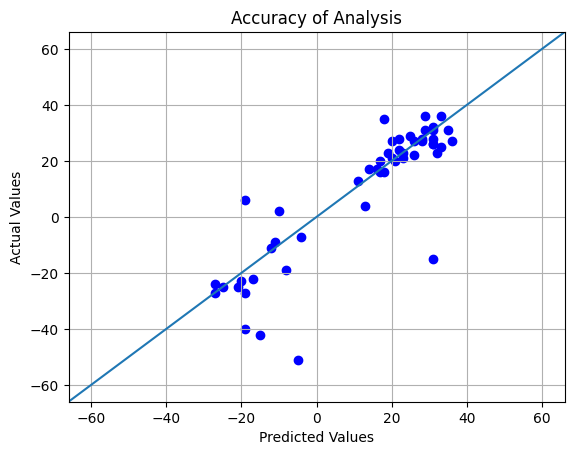

In [23]:
from sklearn.metrics import r2_score

sampleTest = pd.read_csv("sample-vibe.csv", sep=",")

print("R^2 score of best fit regression: " + str(r2_score(sampleTest, write["Vibe"])))

plt.scatter(write["Vibe"], sampleTest, color='blue')
plt.grid(True)
x, y = [-60,-60], [60,60]
plt.axline(x,y)
plt.title("Accuracy of Analysis")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

As we can see above the graph, even this simple regression has an R^2 score of almost 75%. Only 30 iterations were taken and it's already more accurate than the average 3020 student in their first attempt at the class. To me, this is very encouraging progress, especially when I see the data physically graphed and how close most of the data is to being perfectly predicted. A fair amount of that deviation to the left of 0 can likely be explained by my own ambiguity in rating a song as well.\
\
It's worth noting again that there are only 50 entries being tested in this example, which would explain the groupings of points and lack of information between and outside of them. Still, I believe this shows great progress, because on a scale of -60 to 60 that is scaling such ambiguous data, a difference of a few points is really quite acceptable. It's also worth noting that, even at this limited training capacity, only 10% of the points deviate significantly from the line. Imagine what it will look like when there are 10,000 entries to learn from.\
\
My next steps to make this more accurate are going to involve filling out a lot more data in the song-info csv. Then, across the next two assignments for this class I'm hoping to learn practical applications of those optimization speedup strategies and apply those changes on a faster machine, so I can successfully run more iterations. More iterations across a bigger data set should equate to better accuracy, and eventually I'll have a model that I'm comfortable with and I'll move on to the next step in the eventual project. That part is ambiguous and reasonably far in the future, so for now I'll leave it there. 